# Medical Image VAE Analysis
## Modular Convolutional Variational Autoencoder for Medical Imaging

This notebook implements a clean, modular approach to training and evaluating Variational Autoencoders on medical imaging datasets using the MedMNIST collection. The code follows proper Python conventions and avoids unnecessary abstraction.

## 1. Libraries and Configuration

In [35]:
# Standard library imports
import os
import random
from typing import Tuple, Dict, Any
from pathlib import Path

# Third-party imports
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.utils import save_image, make_grid
from tqdm import tqdm

# MedMNIST imports
import medmnist
from medmnist import INFO, Evaluator

print(f"MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

MedMNIST v3.0.2 @ https://github.com/MedMNIST/MedMNIST/
PyTorch version: 2.7.0+cpu
CUDA available: False


In [36]:
data_flag = 'breastmnist'
info = INFO[data_flag]
NUM_CLASSES = len(info['label'])

In [37]:
# Configuration constants
CONFIG = {
    'DATA_FLAG': 'breastmnist',  # Can change to 'breastmnist', 'pathmnist', etc.
    'BATCH_SIZE': 128,
    'NUM_EPOCHS': 20,
    'LEARNING_RATE': 5e-5,
    'LATENT_DIM': 128,
    'BETA_KL': 1.0,  # KL divergence weighting
    'KL_ANNEAL_EPOCHS': 10,
    'SEED': 42,
    'SAVE_INTERVAL': 10,  # Save samples every N epochs
    'OUTPUT_DIR': 'outputs'
}

# Set random seeds for reproducibility
def set_seed(seed: int) -> None:
    """Set random seeds for reproducible results."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

set_seed(CONFIG['SEED'])

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Create output directory
output_dir = Path(CONFIG['OUTPUT_DIR'])
output_dir.mkdir(exist_ok=True)
print(f"Output directory: {output_dir.absolute()}")

Using device: cpu
Output directory: D:\Darmstadt\Deep Generative Model\vae-medical-image-generator\outputs


## 2. Data Preparation and Loading

In [38]:
def get_dataset_info(data_flag: str) -> Dict[str, Any]:
    """Get dataset information and configuration."""
    info = INFO[data_flag]
    dataset_info = {
        'task': info['task'],
        'n_channels': info['n_channels'],
        'n_classes': len(info['label']),
        'data_class': getattr(medmnist, info['python_class']),
        'description': info.get('description', 'No description available')
    }
    return dataset_info

def create_data_loaders(data_flag: str, batch_size: int, download: bool = True) -> Tuple[DataLoader, DataLoader]:
    """Create train and test data loaders."""
    # Get dataset information
    dataset_info = get_dataset_info(data_flag)
    DataClass = dataset_info['data_class']
    
    # Define transforms
    transform = transforms.Compose([
        transforms.ToTensor(),
        # Note: MedMNIST images are already normalized to [0, 1]
    ])
    
    # Load datasets
    train_dataset = DataClass(split='train', transform=transform, download=download)
    test_dataset = DataClass(split='test', transform=transform, download=download)
    
    # Create data loaders
    train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2,
        pin_memory=torch.cuda.is_available()
    )
    
    test_loader = DataLoader(
        dataset=test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2,
        pin_memory=torch.cuda.is_available()
    )
    
    return train_loader, test_loader, dataset_info

# Load data
train_loader, test_loader, dataset_info = create_data_loaders(
    CONFIG['DATA_FLAG'], 
    CONFIG['BATCH_SIZE']
)

print(f"Dataset: {CONFIG['DATA_FLAG']}")
print(f"Task: {dataset_info['task']}")
print(f"Channels: {dataset_info['n_channels']}")
print(f"Classes: {dataset_info['n_classes']}")
print(f"Train samples: {len(train_loader.dataset)}")
print(f"Test samples: {len(test_loader.dataset)}")
print(f"Batches per epoch: {len(train_loader)}")

Dataset: breastmnist
Task: binary-class
Channels: 1
Classes: 2
Train samples: 546
Test samples: 156
Batches per epoch: 5


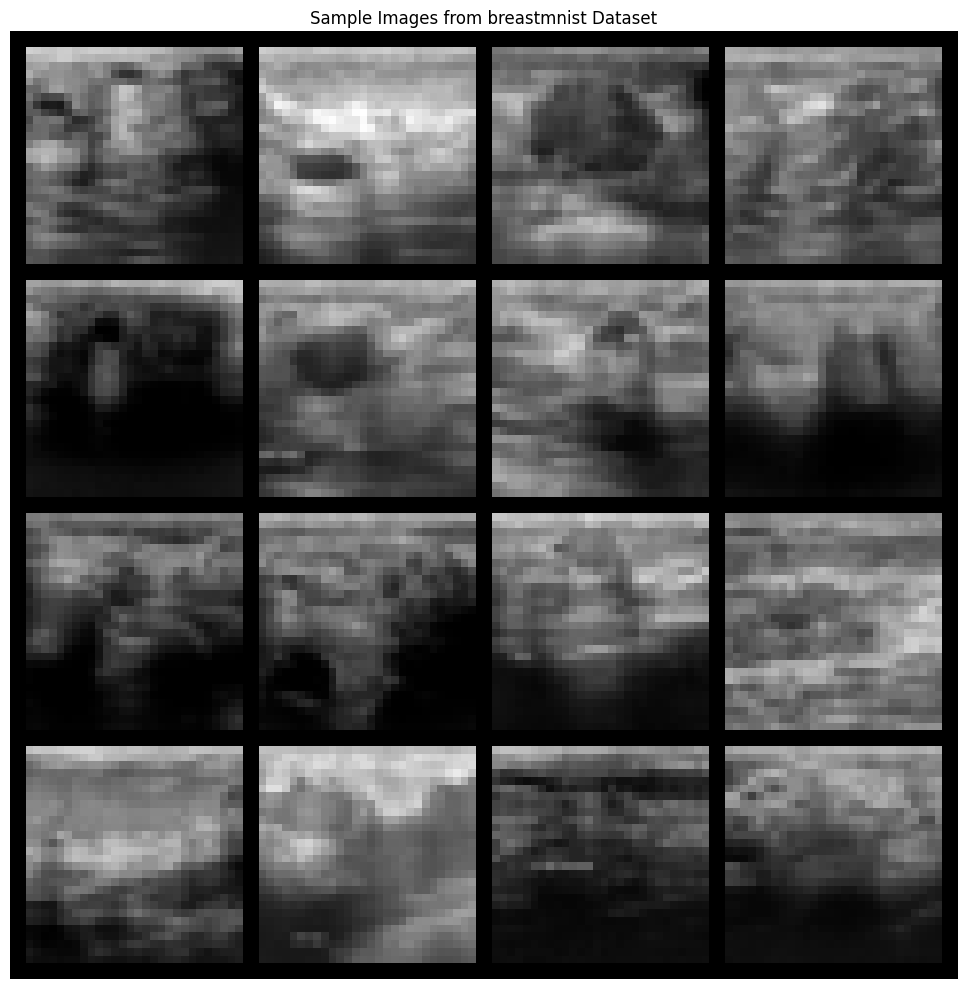

In [39]:
# Visualize sample data
def visualize_samples(data_loader: DataLoader, num_samples: int = 16) -> None:
    """Visualize sample images from the dataset."""
    images, labels = next(iter(data_loader))
    images = images[:num_samples]
    
    # Create grid
    grid = make_grid(images, nrow=4, normalize=True, padding=2)
    
    # Plot
    plt.figure(figsize=(10, 10))
    plt.imshow(grid.permute(1, 2, 0))
    plt.title(f'Sample Images from {CONFIG["DATA_FLAG"]} Dataset')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

visualize_samples(train_loader)

## 3. Model Components: Encoder, Decoder, and VAE

In [40]:
class Encoder(nn.Module):
    """Convolutional encoder for VAE."""
    
    def __init__(self, input_channels: int = 3, latent_dim: int = 128, num_classes: int = NUM_CLASSES):
        super().__init__()
        self.latent_dim = latent_dim
        self.num_classes = num_classes
        self.input_channels = input_channels + num_classes
        
        # Convolutional layers
        self.conv_layers = nn.Sequential(
            # Input: 28x28x3 -> 14x14x32
            nn.Conv2d(self.input_channels, 32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            
            # 14x14x32 -> 7x7x64
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )
        
        # Calculate flattened size
        self.flatten_size = 7 * 7 * 64
        
        # Dense layers
        self.fc_hidden = nn.Linear(self.flatten_size, 1024)
        self.fc_mu = nn.Linear(1024, latent_dim)
        self.fc_logvar = nn.Linear(1024, latent_dim)
        
    def forward(self, x: torch.Tensor, y: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """Forward pass through encoder.
        
        Args:
            x: Input tensor of shape (batch_size, channels, height, width)
            
        Returns:
            Tuple of (mu, logvar) for latent distribution
        """
        # One-hot encode labels
        y_onehot = F.one_hot(y, num_classes=self.num_classes).float().to(x.device)
        y_map = y_onehot.view(y.size(0), self.num_classes, 1, 1).expand(-1, -1, x.size(2), x.size(3))

        # Concatenate label map with input image
        x = torch.cat([x, y_map], dim=1)  # Shape: (B, C+num_classes, H, W)

        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc_hidden(x))
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)

        return mu, logvar

In [41]:
class Decoder(nn.Module):
    """Convolutional decoder for VAE."""
    
    def __init__(self, latent_dim: int = 128, output_channels: int = 3, num_classes: int = NUM_CLASSES):
        super().__init__()
        self.latent_dim = latent_dim
        self.num_classes = num_classes
        
        # Dense layers
        self.fc = nn.Linear(latent_dim + num_classes, 7 * 7 * 64)
        
        # Transpose convolutional layers
        self.deconv_layers = nn.Sequential(
            # 7x7x64 -> 14x14x64
            nn.ConvTranspose2d(64, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            
            # 14x14x64 -> 28x28x32
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            
            # 28x28x32 -> 28x28x16
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            
            # 28x28x16 -> 28x28x output_channels
            nn.ConvTranspose2d(16, output_channels, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()  # Output values in [0, 1]
        )
        
    def forward(self, z: torch.Tensor, y: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """Forward pass through decoder.
        
        Args:
            z: Latent tensor of shape (batch_size, latent_dim)
            
        Returns:
            Reconstructed image tensor
        """

        if y.dim() > 1:
            y = y.view(-1)
        # One-hot encode labels
        y_onehot = F.one_hot(y, num_classes=self.num_classes).float().to(z.device)
        
        # Concatenate latent vector and label
        z = torch.cat([z, y_onehot], dim=1)
        
        # Dense layer
        x = F.relu(self.fc(z))
        
        # Reshape for convolution
        x = x.view(x.size(0), 64, 7, 7)
        
        # Transpose convolutional layers
        x = self.deconv_layers(x)
        
        return x

In [52]:
def reparameterize(mu: torch.Tensor, logvar: torch.Tensor) -> torch.Tensor:
    """Reparameterization trick for VAE sampling."""
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    return mu + eps * std

def vae_loss(recon_x: torch.Tensor, x: torch.Tensor, mu: torch.Tensor, 
             logvar: torch.Tensor, beta: float = 1.0) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    """Calculate VAE loss (reconstruction + KL divergence).
    
    Args:
        recon_x: Reconstructed images
        x: Original images
        mu: Mean of latent distribution
        logvar: Log variance of latent distribution
        beta: KL divergence weighting factor
        
    Returns:
        Tuple of (total_loss, reconstruction_loss, kl_loss)
    """
    # Reconstruction loss (binary cross-entropy)
    recon_loss = F.binary_cross_entropy(recon_x, x, reduction='sum')
    
    # KL divergence loss
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    # Total loss
    total_loss = recon_loss + beta * kl_loss
    
    return total_loss, recon_loss, kl_loss

class VAE(nn.Module):
    """Variational Autoencoder combining encoder and decoder."""
    
    def __init__(self, input_channels: int = 3, latent_dim: int = 128):
        super().__init__()
        self.latent_dim = latent_dim
        self.encoder = Encoder(input_channels, latent_dim)
        self.decoder = Decoder(latent_dim, input_channels)
        
    def forward(self, x: torch.Tensor, y: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """Forward pass through VAE.
        
        Args:
            x: Input images
            
        Returns:
            Tuple of (reconstructed_images, mu, logvar)
        """
        mu, logvar = self.encoder(x, y)
        z = reparameterize(mu, logvar)
        recon_x = self.decoder(z, y)
        return recon_x, mu, logvar
    
    def generate(self, num_samples: int, device: torch.device, label: int = 1) -> torch.Tensor:
        """Generate new samples from random latent codes for a specific class."""
        with torch.no_grad():
            z = torch.randn(num_samples, self.latent_dim, device=device)
            y = torch.full((num_samples,), label, dtype=torch.long, device=device)  # all same label
            samples = self.decoder(z, y)
        return samples

In [43]:
# Initialize model
model = VAE(
    input_channels=dataset_info['n_channels'],
    latent_dim=CONFIG['LATENT_DIM']
).to(device)

# Initialize optimizer
optimizer = optim.Adam(model.parameters(), lr=CONFIG['LEARNING_RATE'])

# Print model summary
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Model initialized with {total_params:,} total parameters")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Model size: {total_params * 4 / 1024 / 1024:.2f} MB (float32)")

Model initialized with 3,965,441 total parameters
Trainable parameters: 3,965,441
Model size: 15.13 MB (float32)


## 4. Training Loop

In [44]:
def train_epoch(model: VAE, train_loader: DataLoader, optimizer: optim.Optimizer,
                device: torch.device, beta: float) -> Dict[str, float]:
    """Train model for one epoch."""
    model.train()
    total_loss = 0.0
    total_recon_loss = 0.0
    total_kl_loss = 0.0
    num_batches = len(train_loader)
    
    with tqdm(train_loader, desc="Training", leave=False) as pbar:
        for batch_idx, (data, labels) in enumerate(pbar):
            data = data.to(device)
            labels = labels.to(device)
        
            # Forward pass
            recon_batch, mu, logvar = model(data, labels)
        
            # Compute loss
            loss, recon_loss, kl_loss = vae_loss(recon_batch, data, mu, logvar, beta)
            
            # Normalize by batch size
            loss = loss / data.size(0)
            recon_loss = recon_loss / data.size(0)
            kl_loss = kl_loss / data.size(0)
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Accumulate losses
            total_loss += loss.item()
            total_recon_loss += recon_loss.item()
            total_kl_loss += kl_loss.item()
            
            # Update progress bar
            pbar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Recon': f'{recon_loss.item():.4f}',
                'KL': f'{kl_loss.item():.4f}'
            })
    
    return {
        'total_loss': total_loss / num_batches,
        'recon_loss': total_recon_loss / num_batches,
        'kl_loss': total_kl_loss / num_batches
    }

def evaluate_model(model: VAE, test_loader: DataLoader, 
                  device: torch.device, beta: float) -> Dict[str, float]:
    """Evaluate model on test set."""
    model.eval()
    total_loss = 0.0
    total_recon_loss = 0.0
    total_kl_loss = 0.0
    num_batches = len(test_loader)
    
    with torch.no_grad():
        for data, labels in test_loader:
            data = data.to(device)
            labels = labels.to(device)
            
            # Forward pass
            recon_batch, mu, logvar = model(data, labels)
            
            # Calculate loss
            loss, recon_loss, kl_loss = vae_loss(recon_batch, data, mu, logvar, beta)
            
            # Normalize by batch size
            loss = loss / data.size(0)
            recon_loss = recon_loss / data.size(0)
            kl_loss = kl_loss / data.size(0)
            
            # Accumulate losses
            total_loss += loss.item()
            total_recon_loss += recon_loss.item()
            total_kl_loss += kl_loss.item()
    
    return {
        'total_loss': total_loss / num_batches,
        'recon_loss': total_recon_loss / num_batches,
        'kl_loss': total_kl_loss / num_batches
    }

In [46]:
# Training loop
train_losses = []
test_losses = []

print("Starting training...")
print(f"Total epochs: {CONFIG['NUM_EPOCHS']}")
print(f"KL annealing over {CONFIG['KL_ANNEAL_EPOCHS']} epochs")

for epoch in range(CONFIG['NUM_EPOCHS']):
    # Calculate beta for KL annealing
    if CONFIG['KL_ANNEAL_EPOCHS'] > 0:
        beta = min(1.0, epoch / CONFIG['KL_ANNEAL_EPOCHS'])
    else:
        beta = CONFIG['BETA_KL']
    
    # Train for one epoch
    train_metrics = train_epoch(model, train_loader, optimizer, device, beta)
    
    # Evaluate on test set
    test_metrics = evaluate_model(model, test_loader, device, beta)
    
    # Store losses
    train_losses.append(train_metrics)
    test_losses.append(test_metrics)
    
    # Print epoch summary
    print(f"Epoch [{epoch+1}/{CONFIG['NUM_EPOCHS']}] β={beta:.3f}")
    print(f"  Train - Loss: {train_metrics['total_loss']:.4f}, "
          f"Recon: {train_metrics['recon_loss']:.4f}, "
          f"KL: {train_metrics['kl_loss']:.4f}")
    print(f"  Test  - Loss: {test_metrics['total_loss']:.4f}, "
          f"Recon: {test_metrics['recon_loss']:.4f}, "
          f"KL: {test_metrics['kl_loss']:.4f}")
    
    # Save samples periodically
    if (epoch + 1) % CONFIG['SAVE_INTERVAL'] == 0:
        with torch.no_grad():
            # Generate new samples
            samples = model.generate(16, device, label=0)
            save_image(samples, output_dir / f'generated_epoch_{epoch+1}.png', 
                      nrow=4, normalize=True)
            
            # Reconstruct test images
            test_data, label = next(iter(test_loader))
            test_data = test_data[:16].to(device)
            label = label[:16].to(device)
            recon_data, _, _ = model(test_data,label)
            
            # Save comparison
            comparison = torch.cat([test_data, recon_data])
            save_image(comparison, output_dir / f'reconstruction_epoch_{epoch+1}.png',
                      nrow=8, normalize=True)
        
        print(f"  Saved samples to {output_dir}")

print("Training completed!")

Starting training...
Total epochs: 20
KL annealing over 10 epochs


Epoch [1/20] β=0.000
  Train - Loss: 486.4311, Recon: 486.4311, KL: 9.8115
  Test  - Loss: 490.5429, Recon: 490.5429, KL: 12.6255


Epoch [2/20] β=0.100
  Train - Loss: 478.8174, Recon: 476.4515, KL: 23.6581
  Test  - Loss: 486.1229, Recon: 482.9467, KL: 31.7627


Epoch [3/20] β=0.200
  Train - Loss: 479.2016, Recon: 470.7592, KL: 42.2124
  Test  - Loss: 487.3250, Recon: 478.9749, KL: 41.7506


Epoch [4/20] β=0.300
  Train - Loss: 478.0888, Recon: 465.8123, KL: 40.9216
  Test  - Loss: 484.1947, Recon: 475.2466, KL: 29.8272


Epoch [5/20] β=0.400
  Train - Loss: 475.8263, Recon: 465.3369, KL: 26.2235
  Test  - Loss: 484.8804, Recon: 477.0799, KL: 19.5013


Epoch [6/20] β=0.500
  Train - Loss: 473.2261, Recon: 463.8173, KL: 18.8175
  Test  - Loss: 481.8120, Recon: 472.5122, KL: 18.5995


Epoch [7/20] β=0.600
  Train - Loss: 472.3714, Recon: 460.7535, KL: 19.3631
  Test  - Loss: 481.7660, Recon: 470.5382, KL: 18.7130


Epoch [8/20] β=0.700
  Train - Loss: 473.1901, Recon: 461.3537, KL: 16.9092
  Test  - Loss: 481.4406, Recon: 471.6156, KL: 14.0355


Epoch [9/20] β=0.800
  Train - Loss: 469.7430, Recon: 459.4375, KL: 12.8819
  Test  - Loss: 480.6344, Recon: 471.5719, KL: 11.3281


Epoch [10/20] β=0.900
  Train - Loss: 470.8655, Recon: 460.5722, KL: 11.4370
  Test  - Loss: 481.1476, Recon: 471.3296, KL: 10.9089
  Saved samples to outputs


Epoch [11/20] β=1.000
  Train - Loss: 469.0660, Recon: 458.0235, KL: 11.0425
  Test  - Loss: 479.7811, Recon: 470.0016, KL: 9.7794


Epoch [12/20] β=1.000
  Train - Loss: 470.4673, Recon: 460.7451, KL: 9.7222
  Test  - Loss: 477.7218, Recon: 468.4473, KL: 9.2746


Epoch [13/20] β=1.000
  Train - Loss: 466.2672, Recon: 456.2592, KL: 10.0081
  Test  - Loss: 477.0887, Recon: 467.5000, KL: 9.5887


Epoch [14/20] β=1.000
  Train - Loss: 463.5385, Recon: 453.8570, KL: 9.6814
  Test  - Loss: 477.3331, Recon: 468.5053, KL: 8.8278


Epoch [15/20] β=1.000
  Train - Loss: 465.0695, Recon: 455.7825, KL: 9.2870
  Test  - Loss: 475.9223, Recon: 467.0931, KL: 8.8291


Epoch [16/20] β=1.000
  Train - Loss: 465.3502, Recon: 455.7988, KL: 9.5514
  Test  - Loss: 474.8577, Recon: 465.6665, KL: 9.1913


Epoch [17/20] β=1.000
  Train - Loss: 462.6591, Recon: 453.0679, KL: 9.5912
  Test  - Loss: 474.2714, Recon: 465.2092, KL: 9.0622


Epoch [18/20] β=1.000
  Train - Loss: 463.0450, Recon: 453.1109, KL: 9.9341
  Test  - Loss: 472.7901, Recon: 463.4237, KL: 9.3664


Epoch [19/20] β=1.000
  Train - Loss: 463.9069, Recon: 454.3124, KL: 9.5945
  Test  - Loss: 473.1621, Recon: 464.5692, KL: 8.5929


Epoch [20/20] β=1.000
  Train - Loss: 459.9934, Recon: 450.7737, KL: 9.2197
  Test  - Loss: 472.4338, Recon: 463.4120, KL: 9.0218
  Saved samples to outputs
Training completed!


## 5. Evaluation and Visualization

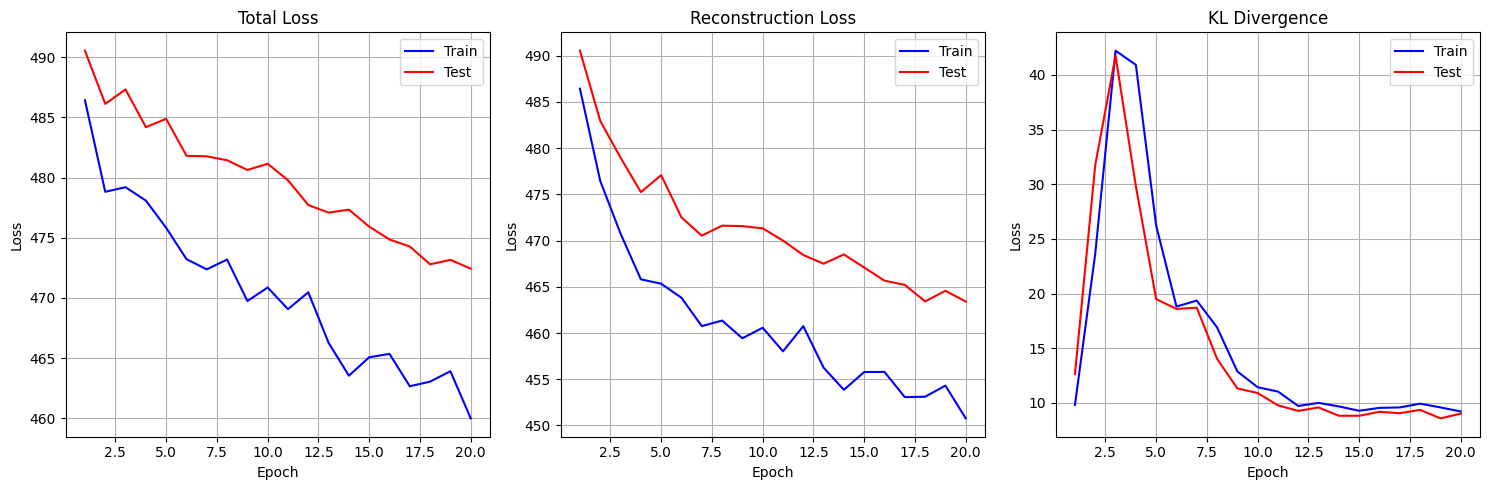

In [53]:
# Plot training curves
def plot_training_curves(train_losses: list, test_losses: list) -> None:
    """Plot training and test loss curves."""
    epochs = range(1, len(train_losses) + 1)
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Total loss
    axes[0].plot(epochs, [m['total_loss'] for m in train_losses], 'b-', label='Train')
    axes[0].plot(epochs, [m['total_loss'] for m in test_losses], 'r-', label='Test')
    axes[0].set_title('Total Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True)
    
    # Reconstruction loss
    axes[1].plot(epochs, [m['recon_loss'] for m in train_losses], 'b-', label='Train')
    axes[1].plot(epochs, [m['recon_loss'] for m in test_losses], 'r-', label='Test')
    axes[1].set_title('Reconstruction Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True)
    
    # KL divergence
    axes[2].plot(epochs, [m['kl_loss'] for m in train_losses], 'b-', label='Train')
    axes[2].plot(epochs, [m['kl_loss'] for m in test_losses], 'r-', label='Test')
    axes[2].set_title('KL Divergence')
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('Loss')
    axes[2].legend()
    axes[2].grid(True)
    
    plt.tight_layout()
    plt.show()

# Plot the curves
plot_training_curves(train_losses, test_losses)

Reconstruction comparison:


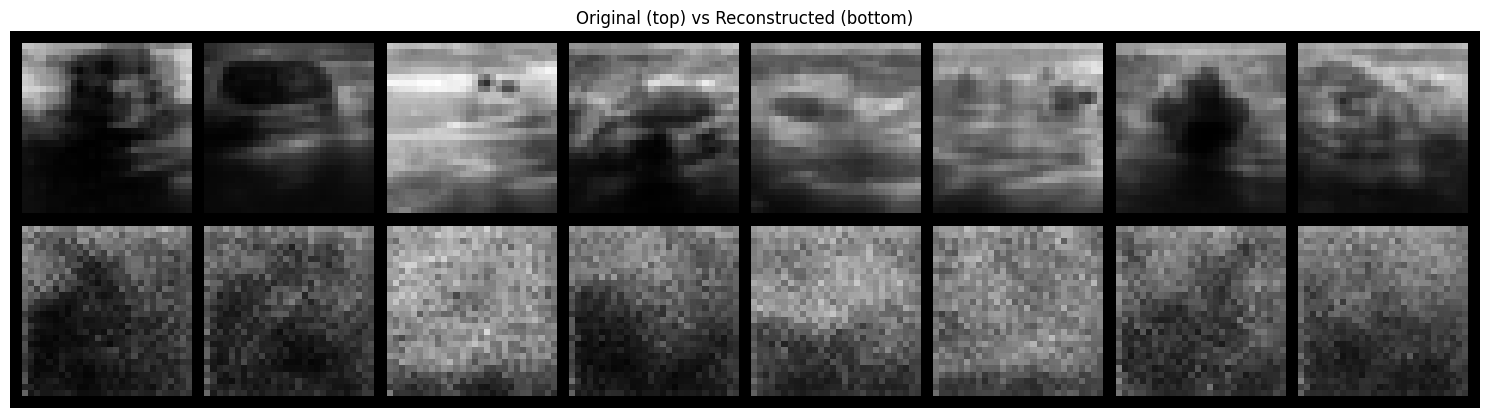


Generated samples:


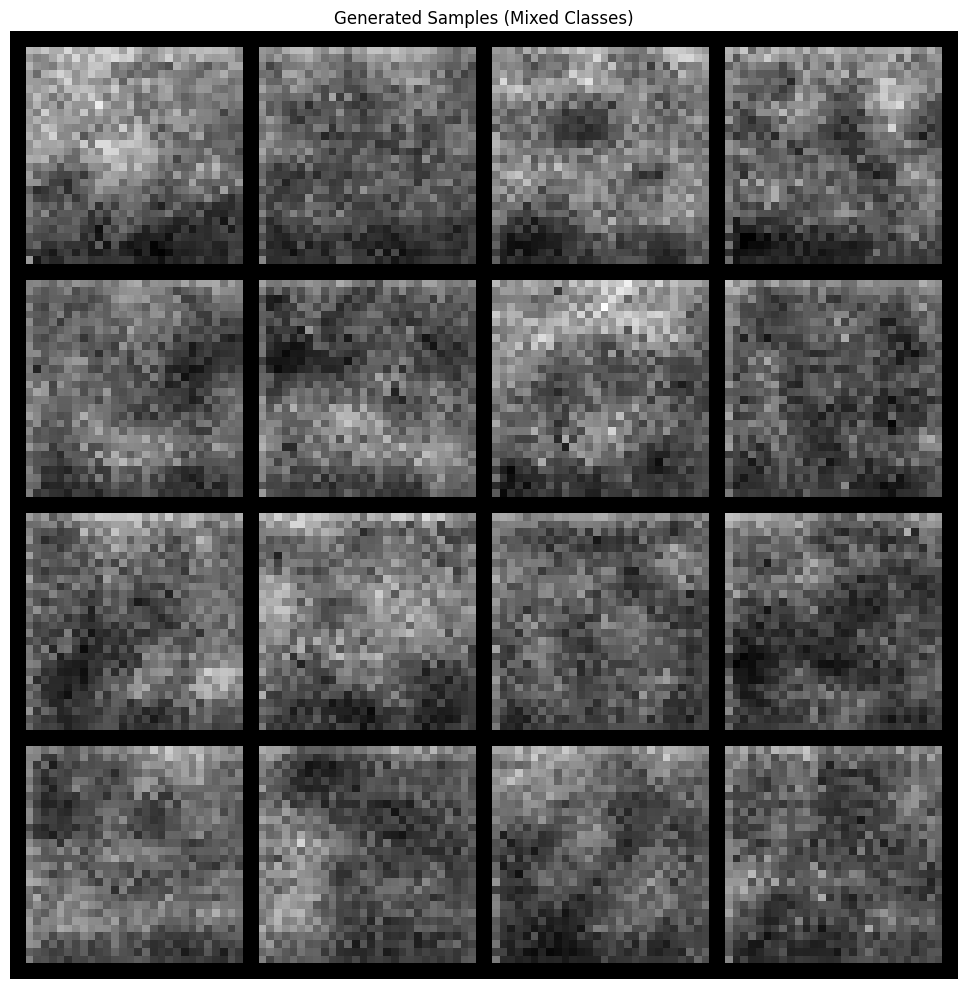


Latent space interpolation:


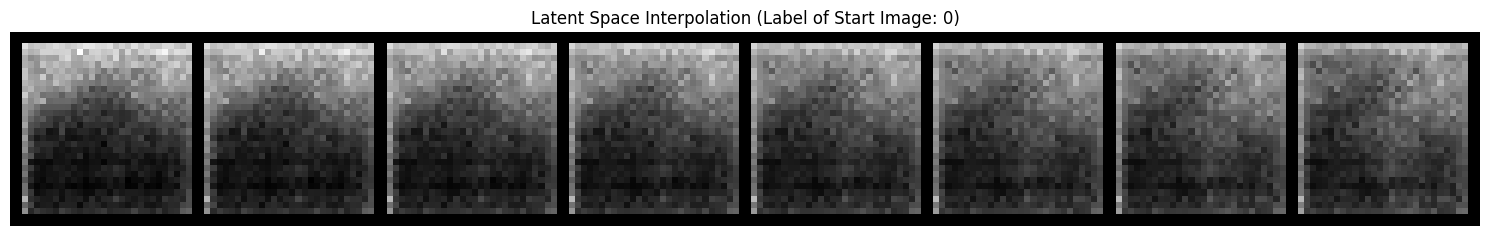

In [54]:
# Visualization functions
def show_reconstruction_comparison(model: VAE, test_loader: DataLoader, 
                                 device: torch.device, num_samples: int = 8) -> None:
    """Show original vs reconstructed images side by side."""
    model.eval()
    
    with torch.no_grad():
        # Get test batch
        test_data, label = next(iter(test_loader))
        test_data = test_data[:num_samples].to(device)
        label = label[:num_samples].to(device)
        
        # Reconstruct
        recon_data, _, _ = model(test_data, label)
        
        # Create comparison
        comparison = torch.cat([test_data, recon_data])
        grid = make_grid(comparison, nrow=num_samples, normalize=True, padding=2)
        
        # Plot
        plt.figure(figsize=(15, 6))
        plt.imshow(grid.permute(1, 2, 0).cpu())
        plt.title('Original (top) vs Reconstructed (bottom)')
        plt.axis('off')
        plt.tight_layout()
        plt.show()

def show_generated_samples(model, device: torch.device, num_samples: int = 16,
                           target_label: int = None, num_classes: int = 10) -> None:
    """Show generated samples from random latent codes, optionally for a specific class."""
    model.eval()

    with torch.no_grad():
        if target_label is not None:
            labels = torch.full((num_samples,), target_label, dtype=torch.long).to(device)
            samples = model.generate(num_samples, device)
            title = f'Generated Samples (Class: {target_label})'
        else:
            labels = torch.randint(0, num_classes, (num_samples,)).to(device)
            samples = model.generate(num_samples, device)
            title = 'Generated Samples (Mixed Classes)'


        grid = make_grid(samples, nrow=4, normalize=True, padding=2)

        # Plot
        plt.figure(figsize=(10, 10))
        plt.imshow(grid.permute(1, 2, 0).cpu())
        plt.title(title)
        plt.axis('off')
        plt.tight_layout()
        plt.show()

def interpolate_latent_space(model, test_loader: DataLoader,
                             device: torch.device, num_steps: int = 8,
                             fixed_label: int = None) -> None:
    """Interpolate between two images in latent space, optionally fixing the label."""
    model.eval()

    with torch.no_grad():
        # Get two test images and their labels
        test_data, labels = next(iter(test_loader))

        img1, img2 = test_data[:2].to(device)
        label1, label2 = labels[:2].to(device)

        # Determine the label for interpolation
        if fixed_label is not None:
            # Use a fixed label for interpolation
            interp_label = torch.full((1,), fixed_label, dtype=torch.long).to(device)
            title_suffix = f' (Fixed Label: {fixed_label})'
        else:
            # Interpolate labels as well, or use the label of the first image
            # For simplicity, we'll use the label of img1 if not fixed
            interp_label = label1.unsqueeze(0)
            title_suffix = f' (Label of Start Image: {label1.item()})'


        # Encode to latent space with their respective labels
        # Assuming model.encoder takes (image, label)
        mu1, _ = model.encoder(img1.unsqueeze(0), label1.unsqueeze(0))
        mu2, _ = model.encoder(img2.unsqueeze(0), label2.unsqueeze(0))

        # Interpolate
        interpolations = []
        for i in range(num_steps):
            alpha = i / (num_steps - 1)
            z_interp = (1 - alpha) * mu1 + alpha * mu2
            # Decode with the chosen interpolation label
            recon = model.decoder(z_interp, interp_label)
            interpolations.append(recon)

        # Create grid
        interpolation_tensor = torch.cat(interpolations)
        grid = make_grid(interpolation_tensor, nrow=num_steps, normalize=True, padding=2)

        # Plot
        plt.figure(figsize=(15, 4))
        plt.imshow(grid.permute(1, 2, 0).cpu())
        plt.title('Latent Space Interpolation' + title_suffix)
        plt.axis('off')
        plt.tight_layout()
        plt.show()

# Show visualizations
print("Reconstruction comparison:")
show_reconstruction_comparison(model, test_loader, device)

print("\nGenerated samples:")
show_generated_samples(model, device)

print("\nLatent space interpolation:")
interpolate_latent_space(model, test_loader, device)

In [55]:
# Save the trained model
model_path = output_dir / 'vae_model.pth'
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'config': CONFIG,
    'dataset_info': dataset_info,
    'train_losses': train_losses,
    'test_losses': test_losses
}, model_path)

print(f"Model saved to: {model_path}")
print(f"Final train loss: {train_losses[-1]['total_loss']:.4f}")
print(f"Final test loss: {test_losses[-1]['total_loss']:.4f}")

Model saved to: outputs\vae_model.pth
Final train loss: 459.9934
Final test loss: 472.4338
